In [1]:
from popsborder.scenarios import run_scenarios, load_scenario_table
from popsborder.simulation import load_configuration
from popsborder.outputs import save_scenario_result_to_pandas

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline

In [3]:
from pathlib import Path
datadir = Path("tests/test_summaries")
resultsdir = "H:/Shared drives/APHIS  Projects/Pathways/Results/use_cases/"
basic_config = load_configuration(datadir / "config.yml")
rate_scenario_table = load_scenario_table(datadir / "contamination_rate_estimation.csv")
inspection_scenario_table = load_scenario_table(datadir / "inspection_scenarios.csv")
consignment_scenario_table = load_scenario_table(datadir / "consignment_scenarios.csv")

## Use Case 1: Estimate contamination rates from high quality inspection data

When inspection data obtained with known statistically valid inspection methods are available, the simulation can be used to estimate the consignment contamination rates by recreating the inspections and calibrating the contamination configuration until similar inspection outcomes are achieved.

In the example below, data from AQIM inspections of cut flower consignments are used to estimate possible contamination rate probability distributions.

In [8]:
num_consignments = 6082
fitted_contamination_rate_results = run_scenarios(
    config=basic_config,
    scenario_table=rate_scenario_table,
    seed=42,
    num_simulations=5,
    num_consignments=num_consignments,
    detailed=False,
)

Running scenario: contamination rate 1
Running scenario: contamination rate 2
Running scenario: contamination rate 3
Running scenario: contamination rate 4
Running scenario: contamination rate 5
Running scenario: contamination rate 6


In [9]:
df_fitted = save_scenario_result_to_pandas(
    fitted_contamination_rate_results,
    config_columns=[
        "name",
        "consignment name",
        "inspection name",
        "contamination/contamination_rate/parameters",
        "contamination/arrangement",
        "contamination/clustered/distribution",
        "contamination/clustered/contaminated_units_per_cluster",
    ],
    result_columns=[
        "true_contamination_rate",
        "false_neg",
        "intercepted",
        "total_missed_contaminants",
        "total_intercepted_contaminants",
        "avg_boxes_opened_completion",
    ],
)

In [34]:
df_fitted['consignment failure rate'] = df_fitted["intercepted"] / num_consignments

In [35]:
# Format dataframe
column_names = ["consignment name", "inspection name", "beta parameters", "contaminant arrangement", "cluster distribution", "infested boxes per cluster", "simulated contamination rate (mean)", "consignment failure rate"]
df_contamination_pretty = df_fitted.iloc[:,[1,2,3,4,5,6,7,13]]

df_contamination_pretty.columns = column_names
df_contamination_pretty.iloc[:,6] = df_contamination_pretty.iloc[:,6].round(decimals=4)
df_contamination_pretty.iloc[:,7] = df_contamination_pretty.iloc[:,7].round(decimals=4)
df_contamination_pretty
#df_contamination_pretty.to_csv(resultsdir + "contamination_rate_results.csv")

,consignment name,inspection name,beta parameters,contaminant arrangement,cluster distribution,infested boxes per cluster,simulated contamination rate (mean),consignment failure rate
0,random mean 0.003 sd 0.032,box hypergeometric 0.1 random,"[0.0088, 2.9121]",random,,,0.0032,0.0533
1,clustered mean 0.003 sd 0.032,box hypergeometric 0.1 random,"[0.0088, 2.9121]",clustered,random,2,0.0028,0.0441
2,random mean 0.0019 sd 0.01875,box hypergeometric 0.1 random,"[0.0102, 5.3839]",random,,,0.0018,0.0490
3,clustered mean 0.0019 sd 0.01875,box hypergeometric 0.1 random,"[0.0102, 5.3839]",clustered,random,2,0.0019,0.0457
4,random mean 0.0004 sd 0.0031,box hypergeometric 0.1 random,"[0.0166, 41.59]",random,,,0.0004,0.0424
5,clustered mean 0.0004 sd 0.0031,box hypergeometric 0.1 random,"[0.0166, 41.59]",clustered,random,2,0.0004,0.0451


In [12]:
# If loading results from saved csv, uncomment and run this chunk.

#df_contamination_pretty = pd.read_csv(resultsdir + "contamination_rate_results.csv")

## Use Case 2: Measure the effect of deviations from sampling protocols

We then use the calibrated contamination rate distribution with mean 0.0019 and standard deviation 0.01875 (mid variability scenario) with a clustered contaminant arrangement to run sampling scenarios with fixed consignment assumptions. The outcomes of these scenarios provide information about the relative impacts of changes to inspection protocols. 

In [33]:
# Hiding very long output for this cell (many printed messages related to clusters)
%%capture capt
num_consignments = 6082
inspection_scenario_results = run_scenarios(
    config=basic_config,
    scenario_table=inspection_scenario_table,
    seed=42,
    num_simulations=1,
    num_consignments=num_consignments,
    detailed=False,
)
# uncomment to print output if desired
# capt.show()

In [14]:
df_inspections = save_scenario_result_to_pandas(
    inspection_scenario_results,
    config_columns=[
        "name",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
        "inspection/cluster/cluster_selection",

    ],
    result_columns=[
        "true_contamination_rate",
        "max_missed_contamination_rate",
        "avg_missed_contamination_rate",
        "max_intercepted_contamination_rate",
        "avg_intercepted_contamination_rate",
        "avg_boxes_opened_completion",
        "avg_boxes_opened_detection",
        "avg_items_inspected_completion",
        "avg_items_inspected_detection",
        "false_neg",
        "intercepted",
        "total_missed_contaminants",
        "total_intercepted_contaminants",
    ],
)

In [36]:
df_inspections['consignment failure rate'] = df_inspections["intercepted"] / num_consignments
contaminated_consignments = df_inspections["false_neg"] + df_inspections["intercepted"]
df_inspections["inspection success rate"] = df_inspections["intercepted"] / contaminated_consignments

In [38]:
# Format dataframe
column_names = ["name", "inspection unit", "sample strategy", "sample parameter", "selection strategy", "cluster selection", "avg contamination rate", "max missed contamination rate", "avg missed contamination rate", "max intercepted contamination rate", "avg intercepted contamination rate", "boxes opened completion", "boxes opened detection", "items inspected completion", "items inspected detection", "missed", "intercepted", "missed contaminants", "intercepted contamininants", "consignment failure rate", "inspection success rate", "sample size method", "selection method"]


In [39]:

df_inspections_pretty = df_inspections.loc[:, df_inspections.columns != 'inspection/hypergeometric/detection_level']
hypergeometric_parameters = df_inspections.iloc[[0,1,2,3,4,5,6,7,12,13,14,15],4]
df_inspections_pretty.iloc[[0,1,2,3,4,5,6,7,12,13,14,15],3] = hypergeometric_parameters
df_inspections_pretty.iloc[:,3] = df_inspections_pretty.iloc[:,3].astype(str)

df_inspections_pretty["sample size method"] = df_inspections_pretty[['inspection/sample_strategy', 'inspection/proportion/value']].agg(' '.join, axis=1)
df_inspections_pretty["selection method"] = df_inspections_pretty[["inspection/unit", 'inspection/selection_strategy', 'inspection/cluster/cluster_selection']].agg(' '.join, axis=1)

df_inspections_pretty.columns = column_names
df_inspections_pretty.iloc[:,6:11] = df_inspections_pretty.iloc[:,6:11].round(decimals=4)
df_inspections_pretty.iloc[:,11:19] = df_inspections_pretty.iloc[:,11:19].astype(int)
df_inspections_pretty.iloc[:,19:21] = df_inspections_pretty.iloc[:,19:21].round(decimals=4)
df_inspections_pretty.iloc[:18,[0,1,21,22,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]
df_inspections_pretty

df_inspections_pretty.to_csv(resultsdir + "inspection_scenario_results.csv")

,name,inspection unit,sample strategy,sample parameter,selection strategy,cluster selection,avg contamination rate,max missed contamination rate,avg missed contamination rate,max intercepted contamination rate,...,items inspected completion,items inspected detection,missed,intercepted,missed contaminants,intercepted contamininants,consignment failure rate,inspection success rate,sample size method,selection method
0,inspection scenario 1,items,hypergeometric,0.05,random,,0.0019,0.0355,0.0036,0.5646,...,56,55,238,161,16087,341617,0.0265,0.4035,hypergeometric 0.05,items random
1,inspection scenario 2,items,hypergeometric,0.05,convenience,,0.0019,0.3683,0.0220,0.5646,...,56,55,308,91,180684,177020,0.0150,0.2281,hypergeometric 0.05,items convenience
2,inspection scenario 3,items,hypergeometric,0.05,cluster,interval,0.0019,0.2849,0.0198,0.5646,...,56,56,275,124,164156,193548,0.0204,0.3108,hypergeometric 0.05,items cluster interval
3,inspection scenario 4,items,hypergeometric,0.05,cluster,random,0.0019,0.4244,0.0186,0.5646,...,56,56,287,112,269536,88168,0.0184,0.2807,hypergeometric 0.05,items cluster random
4,inspection scenario 5,items,hypergeometric,0.1,random,,0.0019,0.1192,0.0061,0.5646,...,28,28,271,128,44645,313059,0.0210,0.3208,hypergeometric 0.1,items random
5,inspection scenario 6,items,hypergeometric,0.1,convenience,,0.0019,0.3683,0.0220,0.5646,...,28,28,308,91,180684,177020,0.0150,0.2281,hypergeometric 0.1,items convenience
6,inspection scenario 7,items,hypergeometric,0.1,cluster,interval,0.0019,0.2849,0.0194,0.5646,...,28,28,303,96,174313,183391,0.0158,0.2406,hypergeometric 0.1,items cluster interval
7,inspection scenario 8,items,hypergeometric,0.1,cluster,random,0.0019,0.2893,0.0230,0.5646,...,28,28,312,87,214724,142980,0.0143,0.2180,hypergeometric 0.1,items cluster random
8,inspection scenario 9,items,proportion,0.02,random,,0.0019,0.2500,0.0095,0.5646,...,753,713,225,174,2965,354739,0.0286,0.4361,proportion 0.02,items random
9,inspection scenario 10,items,proportion,0.02,convenience,,0.0019,0.3683,0.0210,0.5646,...,753,749,303,96,84637,273067,0.0158,0.2406,proportion 0.02,items convenience


In [18]:
# If loading results from saved csv, uncomment and run this chunk.

#df_inspections_pretty = pd.read_csv(resultsdir + "inspection_scenario_results.csv")

In [19]:
colors = {"hypergeometric 0.1": "#1f78b4", "hypergeometric 0.05": "#a6cee3", "proportion 0.02":"#b2df8a"}
patch_1 = mpatches.Patch(color="#a6cee3", label="hypergeometric 0.05")
patch_2 = mpatches.Patch(color="#1f78b4", label="hypergeometric 0.1")
patch_3 = mpatches.Patch(color="#b2df8a", label="proportion 0.02")

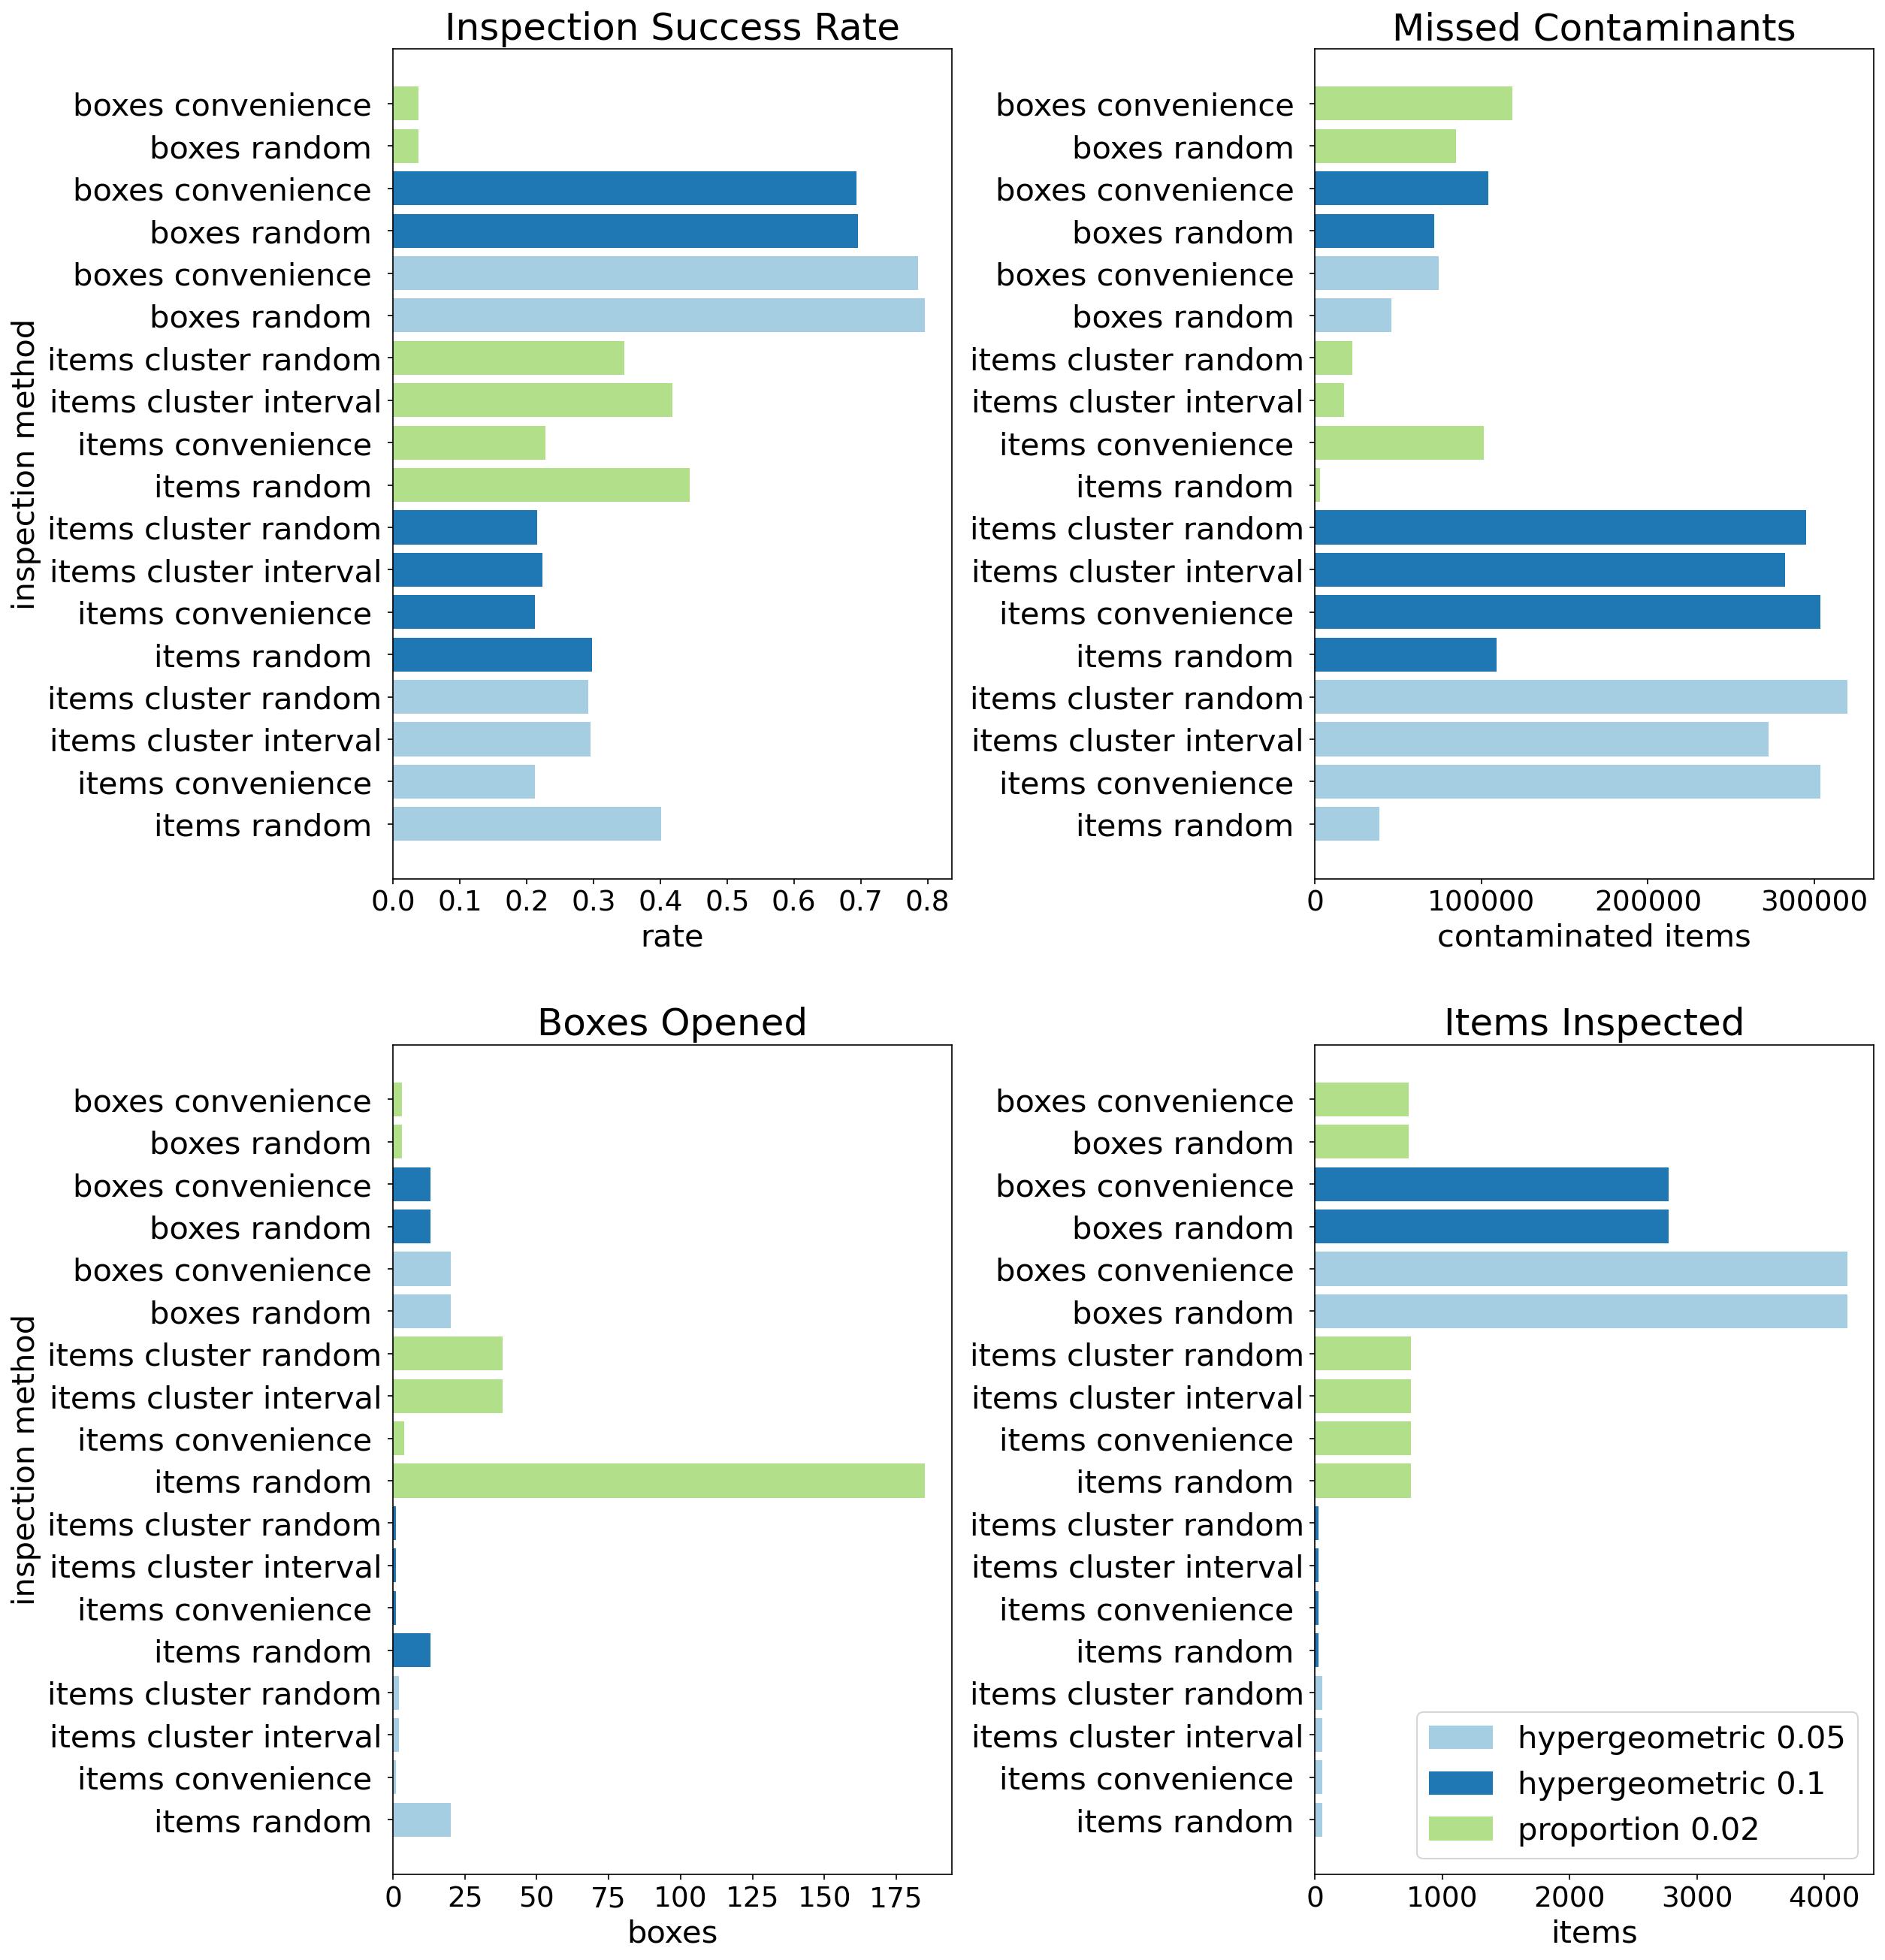

In [20]:
plt.figure(figsize=(18, 18), dpi=150)
plt.subplot(221)
plt.subplots_adjust(wspace=0.65,left=0.15,right=0.97, top=0.95, bottom=0.05)
plt.barh(df_inspections_pretty["name"], df_inspections_pretty["inspection success rate"], color=df_inspections_pretty['sample size method'].replace(colors))
plt.title("Inspection Success Rate", fontsize=24)
plt.ylabel("inspection method", fontsize=20)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(18),labels=df_inspections_pretty["selection method"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(222)
plt.barh(df_inspections_pretty["name"], df_inspections_pretty["missed contaminants"], color=df_inspections_pretty['sample size method'].replace(colors))
plt.title("Missed Contaminants", fontsize=24)
plt.xlabel("contaminated items", fontsize=20)
plt.yticks(ticks=np.arange(18),labels=df_inspections_pretty["selection method"], fontsize=20)
plt.xticks(ticks=[0,100000,200000,300000],fontsize=18)

plt.subplot(223)
plt.subplots_adjust(wspace=0.65,left=0.22,right=0.95)
plt.barh(df_inspections_pretty["name"], df_inspections_pretty["boxes opened completion"], color=df_inspections_pretty['sample size method'].replace(colors))
plt.title("Boxes Opened", fontsize=24)
plt.ylabel("inspection method", fontsize=20)
plt.xlabel("boxes", fontsize=20)
plt.yticks(ticks=np.arange(18),labels=df_inspections_pretty["selection method"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(224)
plt.barh(df_inspections_pretty["name"], df_inspections_pretty["items inspected completion"], color=df_inspections_pretty['sample size method'].replace(colors))
plt.title("Items Inspected", fontsize=24)
plt.xlabel("items", fontsize=20)
plt.legend(handles=[patch_1,patch_2,patch_3], loc = "lower right", fontsize=20)
plt.yticks(ticks=np.arange(18),labels=df_inspections_pretty["selection method"], fontsize=20)
plt.xticks(ticks=[0,1000,2000,3000,4000],fontsize=18)
plt.savefig(resultsdir + "inspection_scenario_plots.png")
plt.show()



##  Use Case 3: Measure the effect of changes in consignment characteristics

We then use the simulation with fixed inspection assumptions to answer questions about how inspection outcomes change with changes in consignments. Using the AQIM inspection protocol (box unit, hypergeometric sample with 0.1 detection level and 0.95 confidence level, random selection), we simulated multiple scenarios to reflect the following consignment scenarios:

* Larger boxes to represent maritime cargo (700 items/box)
* Small boxes in small consignments to represent direct-to-consumer consignments
* Less variability in contamination rates (lower standard deviation)
* Contamination using items versus boxes
* Random contaminant arrangement
* Various clustered contaminant arrangements (small, large, or continuous clusters)

In [21]:
num_consignments = 6082
consignment_scenario_results = run_scenarios(
    config=basic_config,
    scenario_table=consignment_scenario_table,
    seed=42,
    num_simulations=1,
    num_consignments=num_consignments,
    detailed=False,
)

Running scenario: consignment scenario 1
Running scenario: consignment scenario 2
Running scenario: consignment scenario 3
Running scenario: consignment scenario 4
Running scenario: consignment scenario 5
Running scenario: consignment scenario 6
Running scenario: consignment scenario 7
Running scenario: consignment scenario 8
Running scenario: consignment scenario 9
Running scenario: consignment scenario 10
Running scenario: consignment scenario 11
Running scenario: consignment scenario 12
Running scenario: consignment scenario 13
Running scenario: consignment scenario 14
Running scenario: consignment scenario 15
Running scenario: consignment scenario 16


In [22]:
df_consignments = save_scenario_result_to_pandas(
    consignment_scenario_results,
    config_columns=[
        "name",
        "consignment name",
        "consignment/boxes/min",
        "consignment/boxes/max",
        "consignment/items_per_box/default",
        "contamination/contamination_unit",
        "contamination/contamination_rate/distribution",
        "contamination/contamination_rate/parameters",
        "contamination/arrangement",
        "contamination/clustered/distribution",
        "contamination/clustered/contaminated_units_per_cluster",
        "contamination/clustered/random/cluster_item_width",
    ],
    result_columns=[
        "true_contamination_rate",
        "max_missed_contamination_rate",
        "avg_missed_contamination_rate",
        "max_intercepted_contamination_rate",
        "avg_intercepted_contamination_rate",
        "avg_boxes_opened_completion",
        "avg_boxes_opened_detection",
        "avg_items_inspected_completion",
        "avg_items_inspected_detection",
        "false_neg",
        "intercepted",
        "total_missed_contaminants",
        "total_intercepted_contaminants",
    ],
)

In [23]:
df_consignments['consignment failure rate'] = df_consignments["intercepted"] / num_consignments
contaminated_consignments = df_consignments["false_neg"] + df_consignments["intercepted"]
df_consignments["inspection success rate"] = df_consignments["intercepted"] / contaminated_consignments
df_consignments["contaminated_consignments"] = contaminated_consignments

In [24]:
# Format dataframe 
column_names = ["name", "consignment name", "items per box", "contamination unit", "contamination parameters", "contaminant arrangement", "cluster distribution", "contaminated units per cluster", "cluster width", "avg contamination rate", "avg missed contamination rate", "avg intercepted contamination rate", "boxes opened completion", "items inspected completion", "missed contaminants", "intercepted contamininants", "inspection success rate", "contaminated_consignments"]


In [25]:
df_consignments_pretty = df_consignments
df_consignments_pretty.iloc[:,12:17] = df_consignments_pretty.iloc[:,12:17].round(decimals=4)
df_consignments_pretty.iloc[:,17:25] = df_consignments_pretty.iloc[:,17:25].astype(int)
df_consignments_pretty.iloc[:,25:27] = df_consignments_pretty.iloc[:,25:27].round(decimals=4)
df_consignments_pretty.iloc[:,[27]] = df_consignments_pretty.iloc[:,[27]].astype(int)
df_consignments_pretty = df_consignments_pretty.iloc[:,[0,1,4,5,7,8,9,10,11,12,14,16,17,19,23,24,26,27]]
df_consignments_pretty.columns = column_names
df_consignments_pretty

df_consignments_pretty.to_csv(resultsdir + "consignment_scenario_results.csv")

,name,consignment name,items per box,contamination unit,contamination parameters,contaminant arrangement,cluster distribution,max contaminated units per cluster,cluster width,avg contamination rate,avg missed contamination rate,avg intercepted contamination rate,boxes opened completion,items inspected completion,missed contaminants,intercepted contamininants,inspection success rate,contaminated_consignments
0,consignment scenario 1,AQIM,200,box,"[0.0102, 5.3839]",clustered,random,2,,0.0019,0.0069,0.0397,13,2778,51532,306172,0.6967,399
1,consignment scenario 2,Maritime,700,box,"[0.0102, 5.3839]",clustered,random,2,,0.0021,0.0054,0.0369,13,9174,183631,1073137,0.7370,441
2,consignment scenario 3,Direct-to-consumer,50,box,"[0.0102, 5.3839]",clustered,random,2,,0.0015,0.0090,0.0387,9,472,114,4975,0.9370,254
3,consignment scenario 4,High variability (box),200,box,"[0.0088, 2.9121]",clustered,random,2,,0.0028,0.0066,0.0615,13,2778,80890,677098,0.6997,383
4,consignment scenario 5,Mid variability (box),200,box,"[0.0102, 5.3839]",clustered,random,2,,0.0019,0.0069,0.0397,13,2778,51532,306172,0.6967,399
5,consignment scenario 6,Low variability (box),200,box,"[0.0166, 41.59]",clustered,random,2,,0.0004,0.0035,0.0064,13,2778,71521,15714,0.6089,450
6,consignment scenario 7,High variability (item),200,item,"[0.0088, 2.9121]",clustered,random,180,200,0.0032,0.0043,0.0691,13,2778,47302,616141,0.7209,387
7,consignment scenario 8,Mid variability (item),200,item,"[0.0102, 5.3839]",clustered,random,180,200,0.0016,0.0034,0.0330,13,2778,60811,145294,0.6921,406
8,consignment scenario 9,Low variability (item),200,item,"[0.0166, 41.59]",clustered,random,180,200,0.0004,0.0029,0.0059,13,2778,59370,24430,0.6091,463
9,consignment scenario 10,Random (box),200,box,"[0.0102, 5.3839]",random,,,,0.0018,0.0075,0.0338,13,2778,45694,150413,0.7146,417


In [26]:
# If loading results from saved csv, uncomment and run this chunk.

#df_consignments_pretty = pd.read_csv(resultsdir + "consignment_scenario_results.csv")

In [27]:
df_cargo_config = df_consignments_pretty.loc[0:2,:]
df_contamination_rate_scenarios = df_consignments_pretty.loc[3:8,:]
df_contaminant_arrangement_scenarios = df_consignments_pretty.loc[9:15,:]

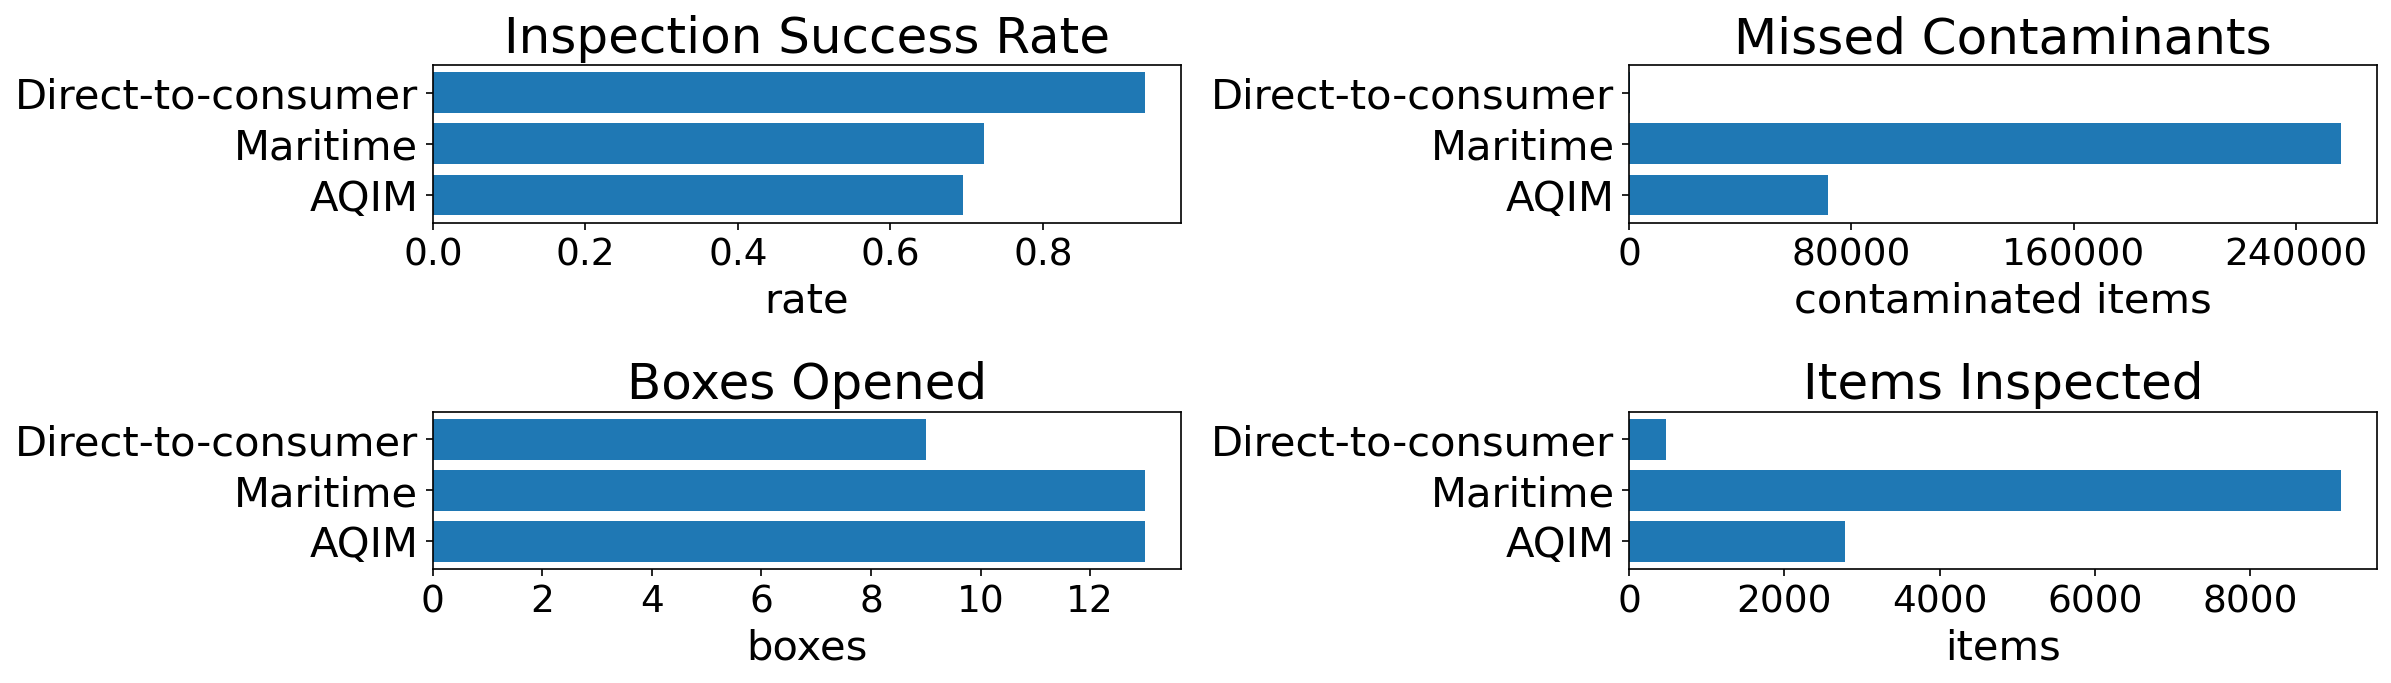

In [28]:
plt.figure(figsize=(16, 4.8), dpi=150)
plt.subplot(221)
plt.subplots_adjust(wspace=0.6,left=0.18,right=0.99,top=0.9, hspace=1.2, bottom=0.2)
plt.barh(df_cargo_config["name"], df_cargo_config["inspection success rate"], color="#1f78b4")
plt.title("Inspection Success Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(3),labels=df_cargo_config["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(222)
plt.barh(df_cargo_config["name"], df_cargo_config["missed contaminants"], color="#1f78b4")
plt.title("Missed Contaminants", fontsize=24)
plt.xlabel("contaminated items", fontsize=20)
plt.yticks(ticks=np.arange(3),labels=df_cargo_config["consignment name"],fontsize=20)
plt.xticks(ticks=[0,80000,160000,240000],fontsize=18)

plt.subplot(223)
plt.barh(df_cargo_config["name"], df_cargo_config["boxes opened completion"], color="#1f78b4")
plt.title("Boxes Opened", fontsize=24)
plt.xlabel("boxes", fontsize=20)
plt.yticks(ticks=np.arange(3),labels=df_cargo_config["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(224)
plt.barh(df_cargo_config["name"], df_cargo_config["items inspected completion"], color="#1f78b4")
plt.title("Items Inspected", fontsize=24)
plt.xlabel("items", fontsize=20)
plt.yticks(ticks=np.arange(3),labels=df_cargo_config["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.savefig(resultsdir + "cargo_config_scenario_plots.png")
plt.show()



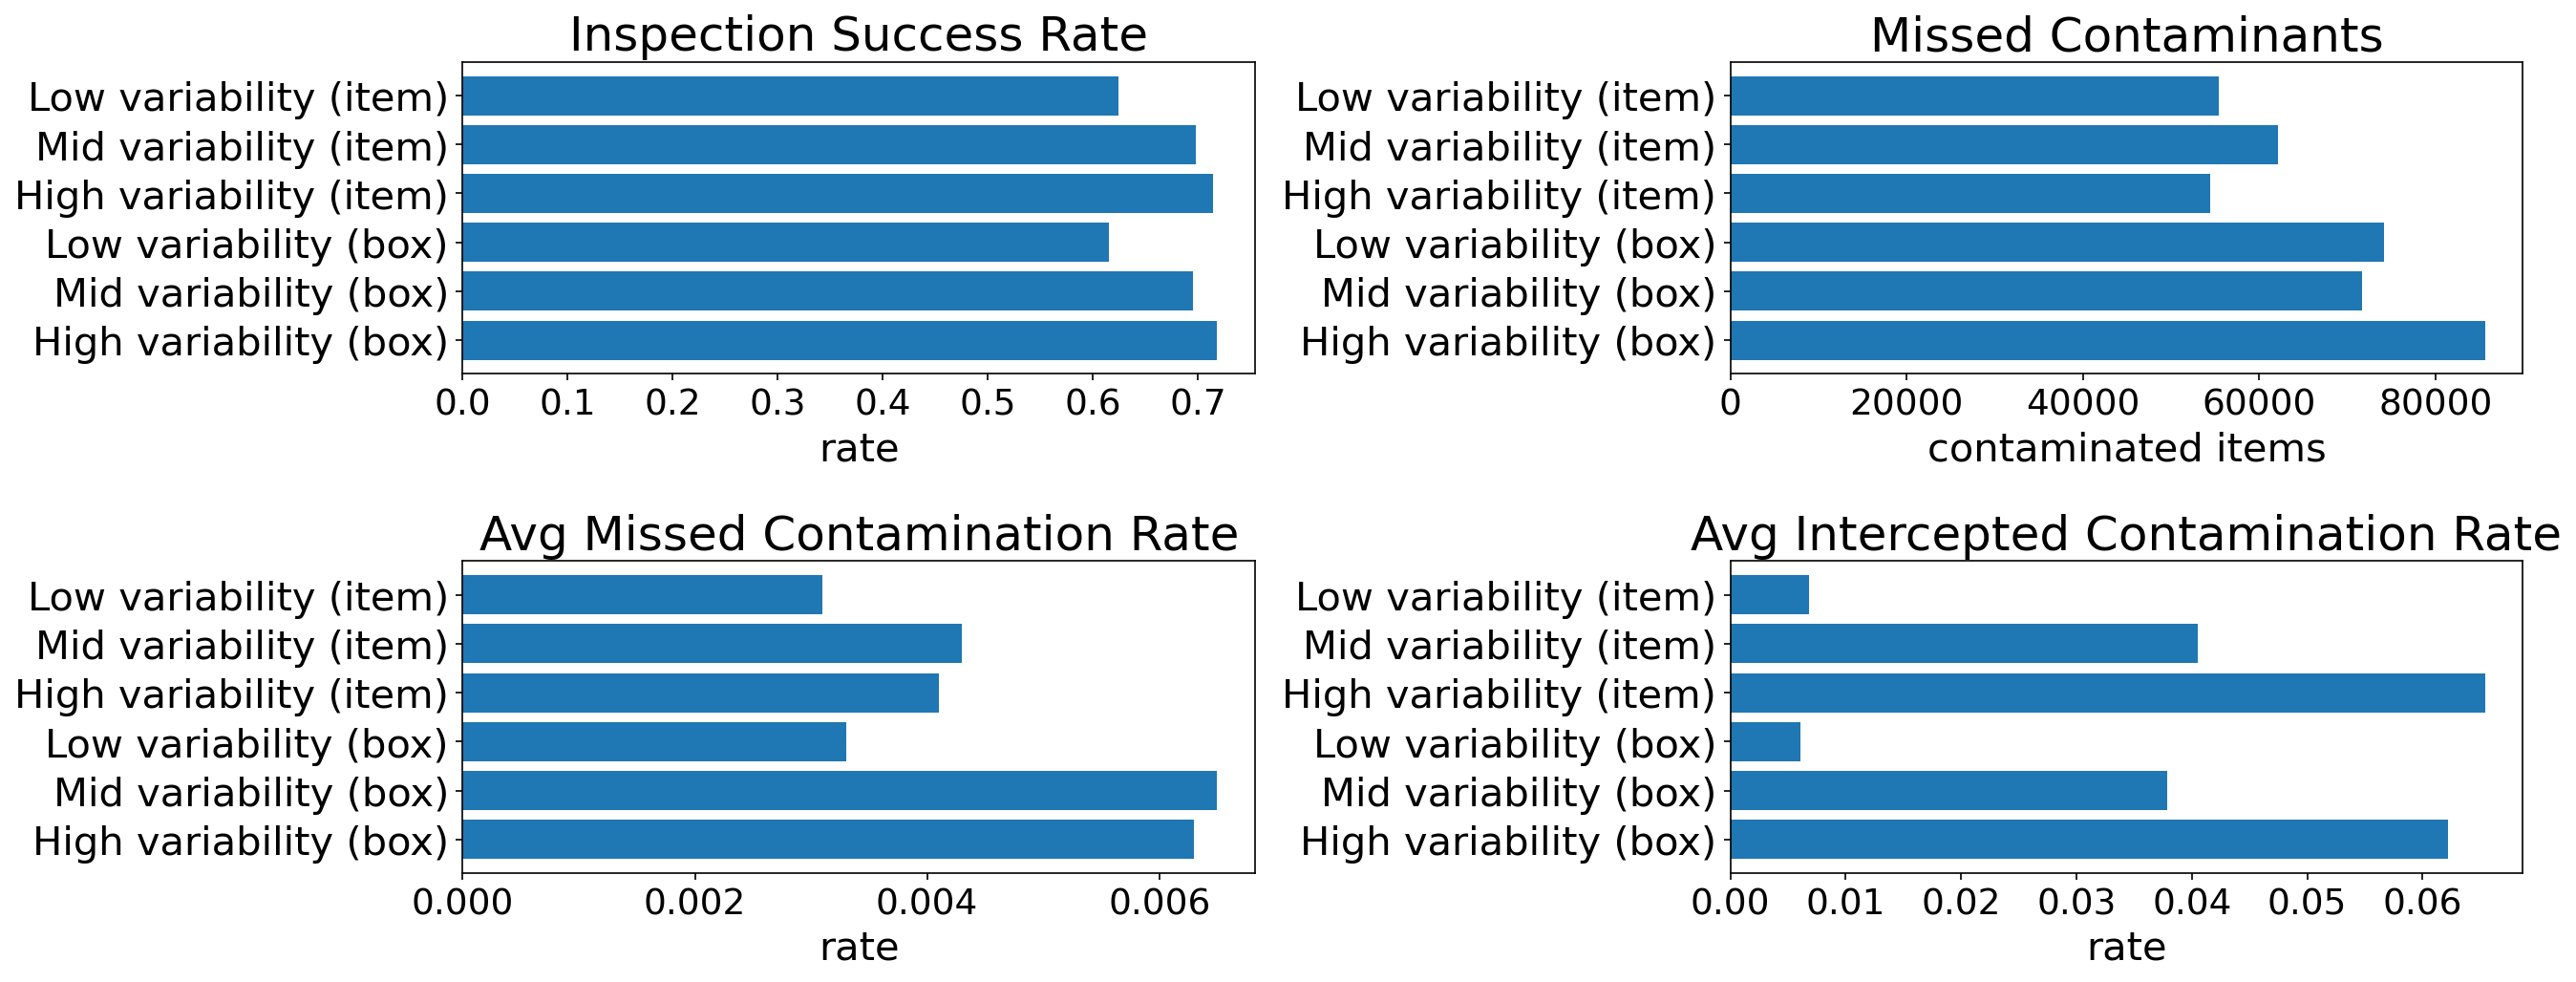

In [29]:
plt.figure(figsize=(18.2, 7.5), dpi=150)
plt.subplot(221)
plt.subplots_adjust(wspace=0.6,left=0.18,right=0.97, hspace=0.6)
plt.barh(df_contamination_rate_scenarios["name"], df_contamination_rate_scenarios["inspection success rate"])
plt.title("Inspection Success Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(6),labels=df_contamination_rate_scenarios["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(222)
plt.barh(df_contamination_rate_scenarios["name"], df_contamination_rate_scenarios["missed contaminants"])
plt.title("Missed Contaminants", fontsize=24)
plt.xlabel("contaminated items", fontsize=20)
plt.yticks(ticks=np.arange(6),labels=df_contamination_rate_scenarios["consignment name"],fontsize=20)
plt.xticks(ticks=[0,20000,40000,60000,80000],fontsize=18)

plt.subplot(223)
plt.barh(df_contamination_rate_scenarios["name"], df_contamination_rate_scenarios["avg missed contamination rate"])
plt.title("Avg Missed Contamination Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(6),labels=df_contamination_rate_scenarios["consignment name"], fontsize=20)
plt.xticks(ticks=[0, 0.002,0.004,0.006], fontsize=18)
plt.subplot(224)
plt.barh(df_contamination_rate_scenarios["name"], df_contamination_rate_scenarios["avg intercepted contamination rate"])
plt.title("Avg Intercepted Contamination Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(6),labels=df_contamination_rate_scenarios["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.savefig(resultsdir + "contamination_rate_scenarios_plots.png")
plt.show()



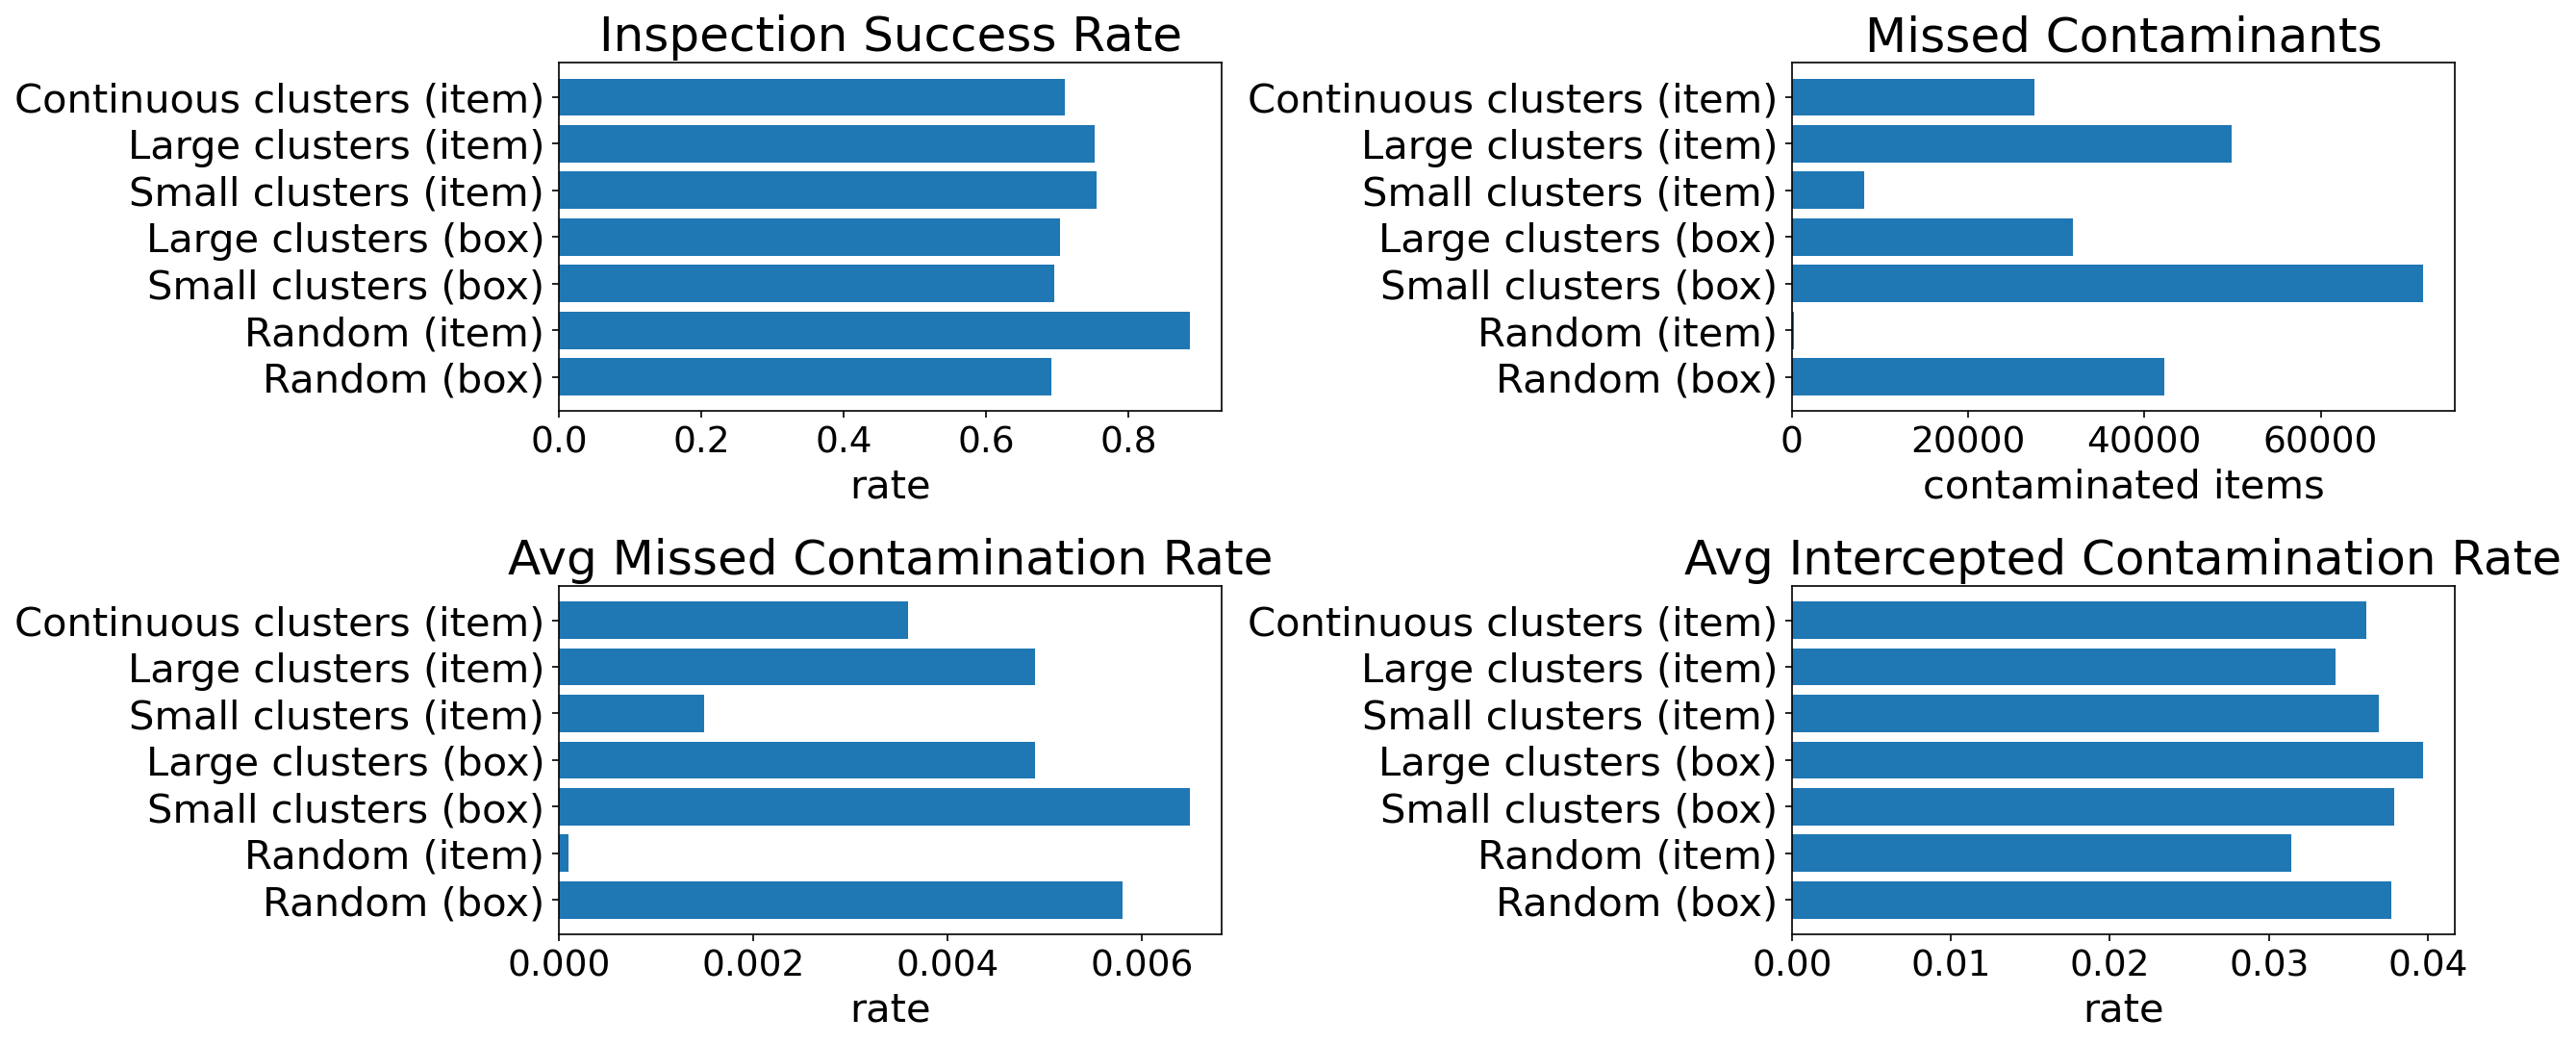

In [30]:
plt.figure(figsize=(18, 8), dpi=150)
plt.subplot(221)
plt.subplots_adjust(wspace=0.86,left=0.22,right=0.95, hspace=0.5)
plt.barh(df_contaminant_arrangement_scenarios["name"], df_contaminant_arrangement_scenarios["inspection success rate"])
plt.title("Inspection Success Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(7),labels=df_contaminant_arrangement_scenarios["consignment name"], fontsize=20)
plt.xticks(fontsize=18)
plt.subplot(222)
plt.barh(df_contaminant_arrangement_scenarios["name"], df_contaminant_arrangement_scenarios["missed contaminants"])
plt.title("Missed Contaminants", fontsize=24)
plt.xlabel("contaminated items", fontsize=20)
plt.yticks(ticks=np.arange(7),labels=df_contaminant_arrangement_scenarios["consignment name"],fontsize=20)
plt.xticks(ticks=[0,20000,40000,60000],fontsize=18)


plt.subplot(223)
plt.barh(df_contaminant_arrangement_scenarios["name"], df_contaminant_arrangement_scenarios["avg missed contamination rate"])
plt.title("Avg Missed Contamination Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(7),labels=df_contaminant_arrangement_scenarios["consignment name"], fontsize=20)
plt.xticks(ticks=[0, 0.002,0.004,0.006], fontsize=18)
plt.subplot(224)
plt.barh(df_contaminant_arrangement_scenarios["name"], df_contaminant_arrangement_scenarios["avg intercepted contamination rate"])
plt.title("Avg Intercepted Contamination Rate", fontsize=24)
plt.xlabel("rate", fontsize=20)
plt.yticks(ticks=np.arange(7),labels=df_contaminant_arrangement_scenarios["consignment name"], fontsize=20)
plt.xticks(ticks=[0,0.01,0.02,0.03,0.04], fontsize=18)
plt.savefig(resultsdir + "contaminant_arrangement_scenarios_plots.png")
plt.show()

